<a href="https://colab.research.google.com/github/zsteve/reprogramming_batch/blob/master/batch_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pykeops[colab]
!pip install wot pegasuspy pot
!git clone -b manu_version https://github.com/zsteve/gWOT
!pip install /content/gWOT
!pip install pathos
!git clone https://github.com/zsteve/reprogramming_batch

     |████████████████████████████████| 368kB 8.6MB/s eta 0:00:01
     |████████████████████████████████| 17.7MB 215kB/s 
  Created wheel for pykeops: filename=pykeops-1.5-cp37-none-any.whl size=514452 sha256=44af1f8ac5eed3713b66b964bc49f87849f1f8e75000ebff03f452607004cfac
  Stored in directory: /root/.cache/pip/wheels/76/c7/d2/aad1237b109c3e01afe215bc1ae9b954bef153b7020fd6f960
Successfully built pykeops
  Found existing installation: cmake 3.12.0
    Uninstalling cmake-3.12.0:
      Successfully uninstalled cmake-3.12.0
     |████████████████████████████████| 61kB 4.8MB/s 
     |████████████████████████████████| 2.2MB 13.0MB/s 
     |████████████████████████████████| 440kB 43.1MB/s 
     |████████████████████████████████| 133kB 46.1MB/s 
     |████████████████████████████████| 153kB 51.7MB/s 
     |████████████████████████████████| 3.2MB 51.0MB/s 
     |████████████████████████████████| 2.2MB 52.3MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !apt-get install cuda=10.2.89-1
# !pip install pykeops
# import pykeops
# pykeops.clean_pykeops()          # just in case old build files are still present
# pykeops.test_torch_bindings()    # perform the compilation

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import wot
import pegasus as pg
from math import *
import ot
import pykeops

import torch
from torch.autograd import grad, Variable
import copy
import scipy as sp
from scipy import stats
import sklearn
import dill
import anndata
import gwot
from gwot import models, util, ts, anndata_utils, altsolver

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_tensor_type(torch.DoubleTensor)

In [ ]:
# set random seed 
np.random.seed(0)
adata = anndata.read_h5ad("/content/drive/MyDrive/reprog_data.h5ad")
cell_sets = wot.io.read_sets("/content/reprogramming_batch/cell_sets.gmt")
obs_celltype = pd.DataFrame(cell_sets.X, dtype = bool, columns = cell_sets.var.index, index = cell_sets.obs.index)
idx_batch = pd.Index.intersection(cell_sets.obs.index, adata.obs.index)
adata_batch = adata[idx_batch, ]
adata_batch.obs = pd.concat([adata_batch.obs, obs_celltype.loc[idx_batch, ]], axis = 1)

adata_batch = adata_batch[adata_batch.obs.day > 4, ]
del adata_batch.uns

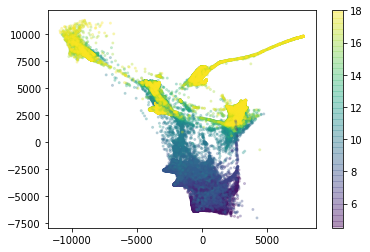

In [ ]:
plt.scatter(adata_batch.obsm["X_fle"].x, adata_batch.obsm["X_fle"].y, c = adata_batch.obs.day, s = 4, alpha = 0.25)
plt.colorbar()

In [ ]:
adata_batch.obs = adata_batch.obs.drop(columns = ["MET", "OPC", "Astrocyte", "Neuron", "SpongioTropho", "ProgenitorTropho", "SpiralArteryTrophoGiant", "RadialGlia"])

In [ ]:
adata_batch.obs.loc[:, "None"] = (adata_batch.obs.iloc[:, 3:].sum(1) == 0)
adata_batch = adata_batch[adata_batch.obs.iloc[:, 3:].sum(1) == 1, :]

In [ ]:
# Ignore OPC onward; ignore MET
# IPS, Stromal, Neural, Epi, Tropho

In [ ]:
t_initial = 8
t_final = 14.5
numcells = 250
dt0 = 0.5
eps_eff = 0.1
eps_df = 0.025
lamda = 2.5e-3

In [ ]:
adata_batch.obs.iloc[:, 3:].sum()

IPS             3676
Stromal        24448
Neural          4307
Epithelial     10465
Trophoblast     6079
None           25087
dtype: int64

In [ ]:
adata_ts = adata_batch[~np.isnan(adata_batch.obs.day), :] 
pg.pca(adata_ts, n_components = 10, features = None)
t_map = np.array(adata_ts.obs.day.unique())
t_map = t_map[t_map >= t_initial]
t_map = t_map[t_map < t_final]
t_map.sort()


Trying to set attribute `.uns` of view, copying.


2021-04-28 04:15:37,559 - pegasus.tools.preprocessing - INFO - Function 'pca' finished in 8.32s.


In [ ]:
c = np.array([x.split('_')[2] for x in adata_batch.obs.index])
c[c == 'C1'] = 0.
c[c == 'C2'] = 1.
c = c.astype(np.float)

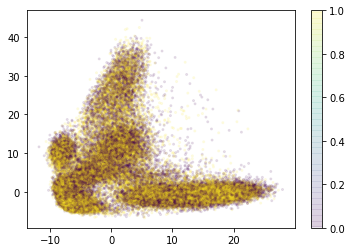

In [ ]:
plt.scatter(adata_batch.obsm["X_pca"][:, 0], adata_batch.obsm["X_pca"][:, 1], s = 4, alpha = 0.1, c = c)
plt.colorbar()

In [ ]:
props = [adata_batch[adata_batch.obs.day == i, :].obs.iloc[:, 3:].sum(0) for i in t_map]
props = [p/p.sum() for p in props]

In [ ]:
# def normalise(x):
#     return x/x.sum()
# props_perturb = [normalise(p * np.random.uniform(size = len(p))) for p in props]
props_perturb = [np.random.dirichlet(10*p + 1e-3) for p in props]

In [ ]:
celltypes = adata_ts.obs.iloc[:, 3:].columns
adata_subsamp = []
for i in range(len(t_map)):
    p = props_perturb[i]/props[i]
    p[np.isnan(p)] = 0
    p[np.isinf(p)] = 0
    p = p/p.sum()
    adata_ = adata_ts[adata_ts.obs.day == t_map[i]]
    q = np.zeros(adata_.shape[0])
    for c in celltypes:
        q[adata_.obs.loc[:, c]] = p.loc[c]
    q = q/q.sum()
    adata_subsamp += [adata_[np.random.choice(adata_.shape[0], size = numcells, p = q), :], ]

In [ ]:
# adata_subsamp = [gwot.anndata_utils.subsamp(adata_ts, t, numcells) for t in t_map]
adata_s = adata_subsamp[0].concatenate(adata_subsamp[1:])
adata_s.obsm["X_pca_orig"] = adata_s.obsm["X_pca"]
days = adata_s.obs.day.unique()
days_tot = adata_s.obs.day.unique().shape[0]

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

In [ ]:
props_subsamp = [adata_s[adata_s.obs.day == i, :].obs.iloc[:, 3:].sum(0) for i in t_map]
props_subsamp = [p/p.sum() for p in props_subsamp]

In [ ]:
i = 7
(props_subsamp[i] - props[i])/(props_subsamp[i] - props_perturb[i])

IPS             -1.027841
Stromal         -5.699498
Neural         118.751212
Epithelial      -6.810371
Trophoblast    275.985361
None            -6.386605
dtype: float64

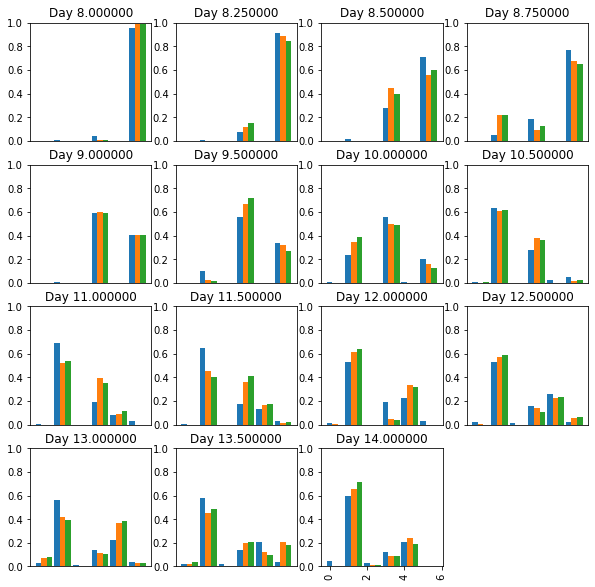

In [ ]:
plt.figure(figsize = (10, 10))
for i in range(len(props)):
    plt.subplot(int(len(props)/4 + 0.5), 4, i+1)
    plt.title("Day %f" % t_map[i])
    width = 0.3
    plt.bar(np.arange(len(props[i].index)), props[i], width = width)
    plt.bar(np.arange(len(props[i].index)) + width, props_perturb[i], width = width)
    plt.bar(np.arange(len(props[i].index)) + 2*width, props_subsamp[i], width = width)
    plt.ylim(0, 1)
    if i != len(props)-1:
        plt.xticks([])
    else:
        plt.xticks(rotation = 90)

In [ ]:
# recompute PCA for subsampled data
pg.pca(adata_s, n_components = adata.obsm["X_pca"].shape[1], features = None)
pg.neighbors(adata_s)
pg.diffmap(adata_s)
adata_s.obsm['X_fle'] = np.array(adata_s.obsm['X_fle'])

2021-04-28 04:15:42,727 - pegasus.tools.preprocessing - INFO - Function 'pca' finished in 0.48s.
2021-04-28 04:15:43,227 - pegasus.tools.nearest_neighbors - INFO - Function 'get_neighbors' finished in 0.50s.
2021-04-28 04:15:43,379 - pegasus.tools.nearest_neighbors - INFO - Function 'calculate_affinity_matrix' finished in 0.15s.
2021-04-28 04:15:43,386 - pegasus.tools.diffusion_map - INFO - Calculating connected components is done.
2021-04-28 04:15:43,403 - pegasus.tools.diffusion_map - INFO - Calculating normalized affinity matrix is done.
2021-04-28 04:15:44,383 - pegasus.tools.diffusion_map - INFO - Detected knee point at t = 108.
2021-04-28 04:15:44,391 - pegasus.tools.diffusion_map - INFO - Function 'diffmap' finished in 1.01s.


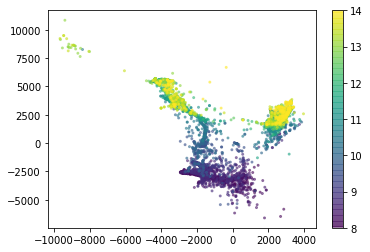

In [ ]:
plt.scatter(adata_s.obsm["X_fle"][:, 0], adata_s.obsm["X_fle"][:, 1], c = adata_s.obs.day, alpha = 0.5, s = 4)
plt.colorbar()

In [ ]:
c_means = np.array([gwot.anndata_utils.get_C_mean(adata_s, t_map[i], t_next = t_map[i+1], mode = "tr") for i in range(0, len(t_map[:-1]))])
c_means_self = np.array([gwot.anndata_utils.get_C_mean(adata_s, t, mode = "self") for t in t_map])

In [ ]:
dt = np.array([t_map[i+1] - t_map[i] for i in range(0, len(t_map)-1)])

In [ ]:
idx = [np.where(adata_s.obs.day == t)[0] for t in t_map]
t_idx = np.zeros(adata_s.shape[0], dtype = np.int64)
for i in range(0, len(idx)):
    t_idx[idx[i]] = i

In [ ]:
dt0 = dt0/dt.sum()
tsdata = gwot.ts.TimeSeries(x = np.array(adata_s.obsm["X_pca"], dtype = np.float64), 
                dt = dt/dt.sum(), 
                t_idx = t_idx, 
                D = eps_eff/(2*dt0))

In [ ]:
dt0

0.08333333333333333

In [ ]:
# solve without growth
model_ng = gwot.models.OTModel(tsdata, lamda = lamda,
        eps_df = eps_df*torch.ones(tsdata.T).cuda(), 
        lamda_i = torch.ones(tsdata.T).cuda(), 
        m_i = torch.ones(tsdata.T).cuda(),
        g_i = torch.ones(tsdata.T, tsdata.x.shape[0]).cuda(),
        kappa = torch.from_numpy(10/tsdata.dt).cuda(), 
        c_scale = torch.from_numpy(c_means).cuda(),
        c_scale_df = torch.from_numpy(c_means_self).cuda(),
        growth_constraint="KL",
        pi_0 = "uniform", 
        device = device,
        use_keops = True)

[pyKeOps] Initializing build folder for dtype=float64 and lang=torch in /root/.cache/pykeops-1.5-cpython-37 ... done.
[pyKeOps] Compiling libKeOpstorch3a8a97625b in /root/.cache/pykeops-1.5-cpython-37:
       formula: Sum_Reduction(Exp(Minus(Sum((Square((Var(0,10,1) - Var(1,10,0))) / Var(2,1,2))))),0)
       aliases: Var(0,10,1); Var(1,10,0); Var(2,1,2); 
       dtype  : float64
... 
[pyKeOps] Compiling pybind11 template libKeOps_template_660bc304e8 in /root/.cache/pykeops-1.5-cpython-37 ... done.
Done.


In [ ]:
model_ng.solve_lbfgs(steps = 25, max_iter = 25, lr = 1, history_size = 50, line_search_fn = 'strong_wolfe', factor = 2, tol = 1e-5, retry_max = 0)
# import gwot.altsolver
# altsolver.solve_adam(model_ng, steps = 500, lr = 1e-3, factor = 2, tol = 1e-5, retry_max = 0, print_steps = 25)

[pyKeOps] Compiling libKeOpstorcheb60771071 in /root/.cache/pykeops-1.5-cpython-37:
       formula: Max_SumShiftExpWeight_Reduction(Var(0,1,1),0,(Exp(Minus(Sum((Square((Var(1,10,1) - Var(2,10,0))) / Var(3,1,2))))) * Var(4,1,0)))
       aliases: Var(0,1,1); Var(1,10,1); Var(2,10,0); Var(3,1,2); Var(4,1,0); 
       dtype  : float64
... 
Done.
[pyKeOps] Compiling libKeOpstorchb750986b59 in /root/.cache/pykeops-1.5-cpython-37:
       formula: Max_SumShiftExpWeight_Reduction(Var(0,1,1),0,(Var(1,1,0) * (Exp(Minus(Sum((Square((Var(2,10,1) - Var(3,10,0))) / Var(4,1,2))))) * Var(5,1,0))))
       aliases: Var(0,1,1); Var(1,1,0); Var(2,10,1); Var(3,10,0); Var(4,1,2); Var(5,1,0); 
       dtype  : float64
... 
Done.
[pyKeOps] Compiling libKeOpstorch55bdf7758c in /root/.cache/pykeops-1.5-cpython-37:
       formula: Max_SumShiftExpWeight_Reduction(Var(0,1,1),0,Var(1,1,1))
       aliases: Var(0,1,1); Var(1,1,1); 
       dtype  : float64
... 
Done.
[pyKeOps] Compiling libKeOpstorch4b9e2c8126 in /root/.

([(0, -35.956184580607506),
  (25, -0.10746491817639695),
  (50, -0.09166375036356524),
  (75, -0.088191903189165),
  (100, -0.08635406075060431),
  (125, -0.08554344915601952),
  (150, -0.08505095776558752),
  (175, -0.08475610668479927),
  (200, -0.08457077040725805),
  (225, -0.08442858466531696),
  (250, -0.08431432027862493),
  (275, -0.08423741694146689),
  (300, -0.08419277789927142),
  (325, -0.08416552845380748),
  (350, -0.08414952267493067),
  (375, -0.08413935454782487),
  (400, -0.08413317941156778),
  (425, -0.08412920870953347),
  (450, -0.08412666819205836),
  (475, -0.08412526525206387),
  (500, -0.08412429888055878),
  (525, -0.08412369147524063),
  (550, -0.08412325607163675),
  (575, -0.0841229433565775),
  (600, -0.08412270041510223)],
 tensor([[-0.2242, -0.2599, -0.0444,  ...,  0.3738,  0.6926,  0.4688],
         [-0.1899, -0.1570, -0.0800,  ...,  0.3665,  0.6908,  0.4740],
         [ 0.2044,  0.1783, -0.0149,  ...,  0.2588,  0.7314,  0.5191],
         ...,
      

In [ ]:
with torch.no_grad():
    P_ng = model_ng.get_P()
    R_ng = model_ng.get_R()
p_ng = (P_ng.T/P_ng.sum(dim = 1)).T
r_ng = (R_ng.T/R_ng.sum(dim = 1)).T

In [ ]:
g = torch.from_numpy(np.array(adata_s.obs.cell_growth_rate)).cuda()
g_i = torch.stack([(torch.from_numpy(np.array(adata_s.obs.cell_growth_rate)).cuda())**(t_map[i+1]-t_map[i]) for i in range(0, tsdata.T-1)]).cuda()
r = torch.stack([(p_ng[i, :]*(g**(t_map[i+1]-t_map[i]))).sum() for i in range(0, model_ng.ts.T-1)])
m_i = torch.cumprod(torch.cat([torch.tensor([1., ]).cuda(), r]), dim = 0)

In [ ]:
model_g = gwot.models.OTModel(tsdata, lamda = lamda,
        eps_df = eps_df*torch.ones(tsdata.T).cuda(), 
        lamda_i = torch.ones(tsdata.T).cuda(), 
        m_i = m_i,
        g_i = g_i.cuda(),
        kappa = torch.from_numpy(10/tsdata.dt).cuda(), 
        c_scale = torch.from_numpy(c_means).cuda(),
        c_scale_df = torch.from_numpy(c_means_self).cuda(),
        growth_constraint="KL",
        pi_0 = "uniform", 
        device = device,
        use_keops = True)

In [ ]:
# altsolver.solve_adam(model_g, steps = 2000, lr = 3e-4, factor = 2, tol = 1e-5, retry_max = 0, print_steps = 25)

In [ ]:
model_g.solve_lbfgs(steps = 50, max_iter = 25, lr = 1, history_size = 10, line_search_fn = 'strong_wolfe', factor = 2, tol = 1e-5, retry_max = 0)

Iteration =  0  Dual obj =  -41.6129552500874  Primal_obj =  9905.233341601634  Gap =  9946.846296851721 Sum =  378.61770155289906
Iteration =  1  Dual obj =  -0.1933563386747114  Primal_obj =  25.889206033530318  Gap =  26.08256237220503 Sum =  1.3453867807673316
Iteration =  2  Dual obj =  nan  Primal_obj =  nan  Gap =  nan Sum =  nan
Iteration =  3  Dual obj =  -0.1253448646514432  Primal_obj =  5.606901082523278  Gap =  5.732245947174721 Sum =  0.9338254343641459
Iteration =  4  Dual obj =  -0.10622613742252929  Primal_obj =  4.899184165174585  Gap =  5.005410302597115 Sum =  1.022106411749792
Iteration =  5  Dual obj =  -0.09605118311098412  Primal_obj =  3.879883630038228  Gap =  3.975934813149212 Sum =  0.9681433394282821
Iteration =  6  Dual obj =  -0.09021075026063366  Primal_obj =  3.892746372518531  Gap =  3.9829571227791645 Sum =  0.9734891021327619
Iteration =  7  Dual obj =  -0.0840573939769613  Primal_obj =  2.5913982691611746  Gap =  2.675455663138136 Sum =  0.952777447

([(0, -41.6129552500874),
  (25, -0.1933563386747114),
  (75, -0.1253448646514432),
  (100, -0.10622613742252929),
  (125, -0.09605118311098412),
  (150, -0.09021075026063366),
  (175, -0.0840573939769613),
  (200, -0.08005421533669922),
  (225, -0.076251120611771),
  (250, -0.07469507472116182),
  (275, -0.07325944104657031),
  (300, -0.07223966736810464),
  (325, -0.07155757388554616),
  (350, -0.07106396143222063),
  (375, -0.07064108407686494),
  (400, -0.07027976539889813),
  (425, -0.07000687945120701),
  (450, -0.0697741120958322),
  (475, -0.06958579178403046),
  (500, -0.06939868733208554),
  (525, -0.06925694718705694),
  (550, -0.06914200025474318),
  (575, -0.06903135088589349),
  (600, -0.06893991037436098),
  (625, -0.06885816900597864),
  (650, -0.06878270771942187),
  (675, -0.06871897243433586),
  (700, -0.06867014283726247),
  (725, -0.06862725605603077),
  (750, -0.06859180624112791),
  (775, -0.06855166456955009),
  (800, -0.06852161655044431),
  (825, -0.0684981485

In [ ]:
with torch.no_grad():
    P = model_g.get_P()
    R = model_g.get_R()
p = (P.T/P.sum(dim = 1)).T
r = (R.T/R.sum(dim = 1)).T

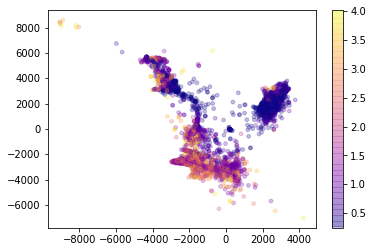

In [ ]:
plt.scatter(adata_s.obsm["X_fle"][:, 0], adata_s.obsm["X_fle"][:, 1], c = g.cpu(), s = 14, alpha = 0.25, cmap = "plasma")
plt.colorbar()

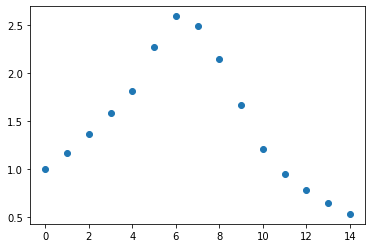

In [ ]:
plt.scatter(np.arange(P.shape[0]), P.sum(-1).cpu())

In [ ]:
d_sample = []
d_infer = []
for t in t_map:
    # compute distance from sample
    mu_sample_spt = adata_s.obsm["X_pca_orig"][adata_s.obs.day == t, :]
    nu_spt = adata_batch.obsm["X_pca"][adata_batch.obs.day == t, :]
    C_sample = sklearn.metrics.pairwise_distances(mu_sample_spt, nu_spt, metric = 'sqeuclidean')
    #d_sample = ot.sinkhorn2(np.ones(mu_sample_spt.shape[0])/mu_sample_spt.shape[0], np.ones(nu_spt.shape[0])/nu_spt.shape[0], C_sample, 0.01*C_sample.mean(), verbose = False)
    d_sample += [ot.emd2(np.ones(mu_sample_spt.shape[0])/mu_sample_spt.shape[0], np.ones(nu_spt.shape[0])/nu_spt.shape[0], C_sample), ]
    mu_spt = adata_s.obsm["X_pca_orig"]
    C_infer = sklearn.metrics.pairwise_distances(mu_spt, nu_spt, metric = 'sqeuclidean')
    mu = p[np.where(t_map == t)[0][0], :].detach().cpu()
    d_infer += [ot.emd2(mu.detach().cpu(), np.ones(nu_spt.shape[0])/nu_spt.shape[0], C_infer, numItermax = 1000000), ]
    print("t = %f, d_sample = %f, d_infer = %f, diff = %f" % (t, d_sample[-1], d_infer[-1], d_infer[-1] - d_sample[-1])) 

t = 8.000000, d_sample = 98.516281, d_infer = 92.373516, diff = -6.142766
t = 8.250000, d_sample = 87.339663, d_infer = 81.743646, diff = -5.596017
t = 8.500000, d_sample = 68.180798, d_infer = 73.705655, diff = 5.524857
t = 8.750000, d_sample = 78.314628, d_infer = 75.654238, diff = -2.660390
t = 9.000000, d_sample = 111.499151, d_infer = 107.900937, diff = -3.598213
t = 9.500000, d_sample = 135.262895, d_infer = 132.628510, diff = -2.634385
t = 10.000000, d_sample = 177.957451, d_infer = 170.673227, diff = -7.284224
t = 10.500000, d_sample = 206.038841, d_infer = 178.621767, diff = -27.417075
t = 11.000000, d_sample = 171.471369, d_infer = 161.666200, diff = -9.805169
t = 11.500000, d_sample = 189.775104, d_infer = 182.626582, diff = -7.148522
t = 12.000000, d_sample = 251.270433, d_infer = 227.493314, diff = -23.777119
t = 12.500000, d_sample = 326.779357, d_infer = 259.645533, diff = -67.133825
t = 13.000000, d_sample = 239.436058, d_infer = 238.832165, diff = -0.603893
t = 13.5000

In [ ]:
props_gwot = [np.array([p[i, adata_s.obs.loc[:, c]].sum().item() for c in celltypes]) for i in range(len(t_map))]
for x in props_gwot:
    x = x/x.sum()

In [ ]:
def KL(a, b):
    eps = 1e-16
    return ((a+eps)*np.log((a+eps)/(b+eps))).sum()

def TV(a, b):
    return (np.abs(a - b)*0.5).sum()

kl_gwot =    [KL(np.array(props[i]), np.array(props_gwot[i])) for i in range(len(props))]
kl_subsamp = [KL(np.array(props[i]), np.array(props_subsamp[i])) for i in range(len(props))]

plt.hist(kl_gwot, alpha = 0.5, label = "gwot", bins = np.linspace(0, 2.5, 100))
plt.hist(kl_subsamp, alpha = 0.5, label = "subsamp", bins = np.linspace(0, 2.5, 100))
plt.legend()
plt.xlabel("KL( true | $\\cdot$ )")

NameError: ignored

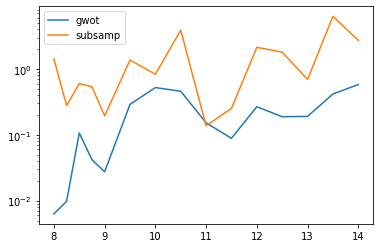

In [ ]:
plt.plot(t_map, kl_gwot, label = "gwot")
plt.plot(t_map, kl_subsamp, label = 'subsamp')
plt.yscale("log")
plt.legend()

In [ ]:
np.mean(kl_gwot), np.mean(kl_subsamp)

(0.22342887844028667, 1.546928588727207)

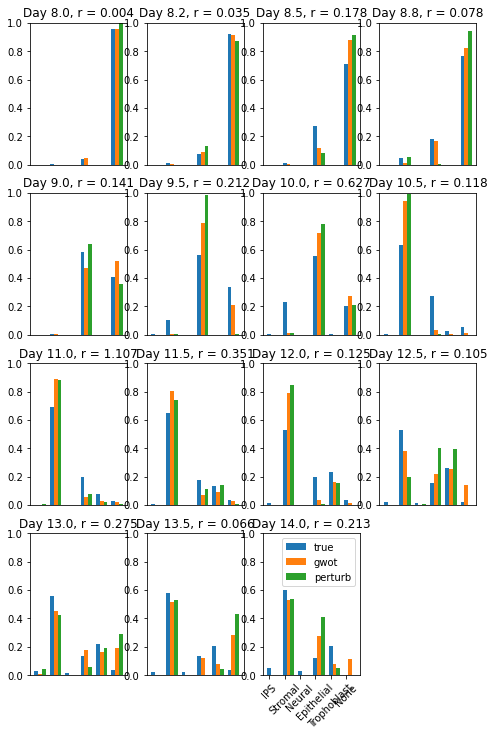

In [ ]:
plt.figure(figsize = (8, 12))
for i in range(len(props)):
    plt.subplot(int(len(props)/4 + 0.5), 4, i+1)
    plt.title("Day %0.1f, r = %0.3f" % (t_map[i], kl_gwot[i]/kl_subsamp[i]))
    width = 0.25
    plt.bar(np.arange(len(props[i].index)), props[i], width = width, alpha = 1, label = "true")
    plt.bar(np.arange(len(props[i].index)) + width, props_gwot[i], width = width, alpha = 1, label = "gwot")
    plt.bar(np.arange(len(props[i].index)) + 2*width, props_subsamp[i], width = width, alpha = 1, label = "perturb")
    plt.ylim(0, 1)
    if i == len(props)-1:
        plt.xticks(np.arange(len(props[i].index)), props[i].index)
        plt.xticks(rotation = 45)
        plt.legend()
    else:
        plt.xticks([])

In [ ]:
np.mean(kl_gwot), np.mean(kl_subsamp)

(0.22342887844028667, 1.546928588727207)

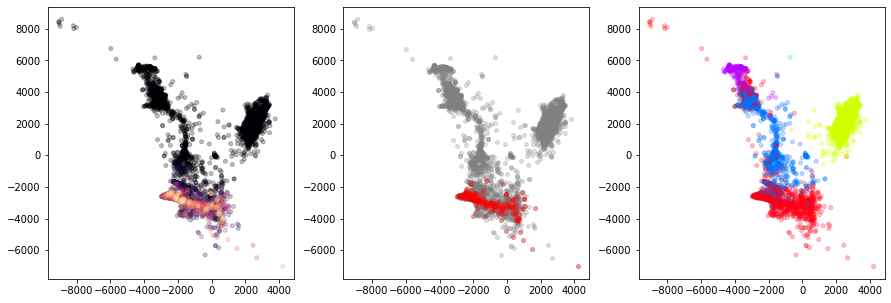

In [ ]:
i = 1
rho = p_ng[i, :].cpu()
perm = np.argsort(rho)
plt.figure(figsize = (15, 5))
plt.subplot(1, 3, 1)
plt.scatter(adata_s.obsm["X_fle"][perm, 0], adata_s.obsm["X_fle"][perm, 1], c = rho[perm], alpha = 0.25, s = 16, vmin = 0, vmax = np.quantile(rho, 0.995), cmap = "magma")
plt.subplot(1, 3, 2)
plt.scatter(adata_s.obsm["X_fle"][:, 0], adata_s.obsm["X_fle"][:, 1], alpha = 0.25, s = 16, color = "grey")
plt.scatter(adata_s.obsm["X_fle"][tsdata.t_idx == i, 0], adata_s.obsm["X_fle"][tsdata.t_idx == i, 1], alpha = 0.25, s = 16, color = "red")
plt.subplot(1, 3, 3)
plt.scatter(adata_s.obsm["X_fle"][:, 0], adata_s.obsm["X_fle"][:, 1], c = np.where(np.array(adata_s.obs.iloc[:, 3:-1]))[1], alpha = 0.25, cmap = "hsv", s = 16)

In [ ]:
pg.neighbors(adata_s)
pg.umap(adata_s)

2021-04-27 05:25:52,566 - pegasus.tools.nearest_neighbors - INFO - Found cached kNN results, no calculation is required.
2021-04-27 05:25:52,567 - pegasus.tools.nearest_neighbors - INFO - Function 'get_neighbors' finished in 0.00s.
2021-04-27 05:25:52,686 - pegasus.tools.nearest_neighbors - INFO - Function 'calculate_affinity_matrix' finished in 0.12s.
2021-04-27 05:25:52,688 - pegasus.tools.nearest_neighbors - INFO - Found cached kNN results, no calculation is required.
2021-04-27 05:25:52,689 - pegasus.tools.nearest_neighbors - INFO - Function 'get_neighbors' finished in 0.00s.
UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.5, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=0, repulsion_strength=1.0,
     set_op_

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Tue Apr 27 05:26:02 2021 Finished Nearest Neighbor Search
Tue Apr 27 05:26:04 2021 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue Apr 27 05:26:13 2021 Finished embedding
2021-04-27 05:26:13,689 - pegasus.tools.visualization - INFO - Using umap kNN graph because number of cells 3750 is smaller than 4096 or knn_indices is not provided.
2021-04-27 05:26:13,690 - pegasus.tools.visualization - INFO - Function 'umap' finished in 21.00s.


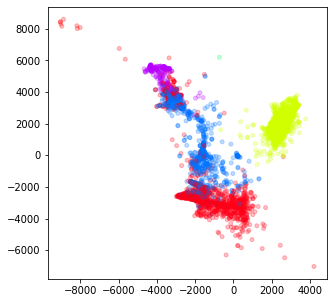

In [ ]:
plt.figure(figsize = (5, 5))
plt.scatter(adata_s.obsm["X_fle"][:, 0], adata_s.obsm["X_fle"][:, 1], c = np.where(np.array(adata_s.obs.iloc[:, 3:-1]))[1], alpha = 0.25, cmap = "hsv", s = 16)